# Emission Impact Analysis (Case: RTS)

In this analysis, we want to study the emissions Impact of virtual bids/offers in a grid

## Dependencies and Data Preparation

#### Packages and Diretory

In [1]:
#make sure it is in "GridAnalysis.jl" 
cd("/home/rafaela/Documents/PUC/LAMPS/github/GridAnalysis.jl")

In [2]:
pwd()

"/home/rafaela/Documents/PUC/LAMPS/github/GridAnalysis.jl"

In [3]:
using Pkg
Pkg.activate("./examples/RTS/emission_impact_analysis_RTS")

In [4]:
Pkg.instantiate()

In [5]:
using Logging 
Logging.disable_logging(Logging.Info) #script to disable info messages 
Logging.disable_logging(Logging.Warn) #script to disable warning messages

LogLevel(1001)

In [6]:
using Dates
using DataFrames
using GridAnalysis
using Gurobi
using PowerSystems
using PowerSimulations
using Test
using Measures
using Plots

const PSY = PowerSystems

PowerSystems

#### Getting the data

In [7]:
# set directory
rts_dir = download("https://github.com/GridMod/RTS-GMLC", "master", mktempdir())
# Or clone the directory and open as:
# for example: rts_dir = "/home/rafaela/Documents/PUC/LAMPS/github/RTS-GMLC"
rts_src_dir = joinpath(rts_dir, "RTS_Data", "SourceData")
rts_siip_dir = joinpath(rts_dir, "RTS_Data", "FormattedData", "SIIP");

#### Uploading Utils

Might not work if running lines manually 
(solution: edit to be the path for this examples directory for example: 'example_dir = "./examples/RTS/"')

In [8]:
example_dir = "./examples/RTS/"

include(joinpath(example_dir, "utils.jl")) # case utilities
include(joinpath(example_dir, "modify_RTS.jl")) # functions that modify the RTS problem

rts_modifier_function!

#### Data Prep and Build Market Simulator
define solvers for Unit Commitment (UC), Real Time (RT) and Economic Dispatch (ED)

In [9]:
solver_uc = optimizer_with_attributes(Gurobi.Optimizer)
solver_rt = optimizer_with_attributes(Gurobi.Optimizer)
solver_ed = optimizer_with_attributes(Gurobi.Optimizer)

MathOptInterface.OptimizerWithAttributes(Gurobi.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[])

## Define analysis to be done

In [10]:
Network = [DCPPowerModel]
Ramp = [true]
Minimal_generation = [true]
Reserve = [true]
Offer_Bus = ["Austen", "Bloch", "Chifa"]
bidding_period = [collect(1:24)]
Offer_Bus_mix = ["Austen", "Bloch", "Chifa"]
Load_Bus_mix = ["Aubrey", "Barkla", "Caesar"] # [wind, solar, wind]
renewable = ["122_WIND_1","215_PV_1","303_WIND_1"]
directory_name = ["Net_DCPP_Load_Austen_Offer_Aubrey_period_1-24", "Net_DCPP_Load_Bloch_Offer_Barkla_period_1-24", "Net_DCPP_Load_Chifa_Offer_Caesar_period_1-24"]

3-element Vector{String}:
 "Net_DCPP_Load_Austen_Offer_Aubrey_period_1-24"
 "Net_DCPP_Load_Bloch_Offer_Barkla_period_1-24"
 "Net_DCPP_Load_Chifa_Offer_Caesar_period_1-24"

#### Create a DataFrame where each line represents one analysis 

In [11]:
df = DataFrame(Network = [], 
               Ramp = [],
               Minimal_generation = [],
               Reserve = [],
               Offer_Bus = [],
               bidding_period = []) 

for a in Network 
    for b in Ramp 
        for c in Minimal_generation 
            for d in Reserve
                for e in Offer_Bus
                    for f in bidding_period
                        new_data = DataFrame(Network = [Dict("DA"=>a, "RT"=>a)], 
                        Ramp = [Dict("DA"=>b, "RT"=>b)],
                        Minimal_generation = [Dict("DA"=>c, "RT"=>c)],
                        Reserve = [d],
                        Offer_Bus = [e],
                        bidding_period = [f])
                        append!(df, new_data)
                    end
                end
            end
        end
    end
end
df[!,5]

3-element Vector{Any}:
 "Austen"
 "Bloch"
 "Chifa"

In [12]:
df_mix = DataFrame(Network = [], 
               Ramp = [],
               Minimal_generation = [],
               Reserve = [],
               Offer_Bus = [],
               Load_Bus = [],
               bidding_period = [],
               directory_name=[],
               renewable = []) 

for (k,i) in enumerate(Offer_Bus)
    new_data_1 = DataFrame(Network = [Dict("DA"=>DCPPowerModel, "RT"=>DCPPowerModel)],
    Ramp = [Dict("DA"=>true, "RT"=>true)],
    Minimal_generation = [Dict("DA"=>false, "RT"=>false)],
    Reserve = [true],
    Offer_Bus = [i],
    Load_Bus = Load_Bus_mix[k],
    bidding_period = [collect(1:24)],
    directory_name = directory_name[k],
    renewable = renewable[k])
    append!(df_mix, new_data_1)
end

df_mix[!, 5:8]

,Offer_Bus,Load_Bus,bidding_period
,Any,Any,Any
1,Austen,Aubrey,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]"
2,Bloch,Barkla,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]"
3,Chifa,Caesar,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]"


#### Define range quota and period to be analysed

In [13]:
range_quota = Float64.(collect(0:1:4))
range_quota_mix = Float64.(collect(0:1:4))
initial_time = Date("2020-09-01")
period_analysed = [5,16,19,20]
initial_bidding_time = DateTime("2020-09-01")
path = "results"

"results"

## Run & Load all the simulations

In [15]:
run_set_of_simulations(df, rts_src_dir, rts_siip_dir, example_dir, solver_uc, solver_ed, solver_rt,
    range_quota, initial_time, initial_bidding_time, path)

In [20]:
run_set_of_simulations_mix(df_mix, rts_src_dir, rts_siip_dir, example_dir, solver_uc, solver_ed, 
    solver_rt, range_quota_mix, range_quota_mix, initial_time, initial_bidding_time, path)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
  Step:                  1
  problem:               RT
  Simulation Timestamp:  2020-09-01T23:45:00


In [14]:
lines=[1,2,3]
period_analysed=[[5],[16],[19],[20]] 

4-element Vector{Vector{Int64}}:
 [5]
 [16]
 [19]
 [20]

### Generate graphics 

#### Generation stack virtual

In [15]:
graphic="plot_generation_stack_virtual"
plt_g=load_plot_set_of_simulations(
    df, 
    example_dir, 
    rts_src_dir,
    rts_siip_dir,
    solver_uc, 
    solver_ed, 
    solver_rt, 
    range_quota, 
    initial_time,
    lines,
    period_analysed,
    initial_bidding_time,
    path,
    graphic,
    true,
)

3×4×2 Array{Any, 3}:
[:, :, 1] =
 Plot{Plots.GRBackend() n=6}  …  Plot{Plots.GRBackend() n=6}
 Plot{Plots.GRBackend() n=6}     Plot{Plots.GRBackend() n=6}
 Plot{Plots.GRBackend() n=6}     Plot{Plots.GRBackend() n=6}

[:, :, 2] =
 Plot{Plots.GRBackend() n=5}  …  Plot{Plots.GRBackend() n=5}
 Plot{Plots.GRBackend() n=5}     Plot{Plots.GRBackend() n=5}
 Plot{Plots.GRBackend() n=5}     Plot{Plots.GRBackend() n=5}

In [ ]:
graphic="plot_generation_stack_virtual"

plt_g_A=load_plot_set_of_simulations(
    df,  
    example_dir, 
    rts_src_dir,
    rts_siip_dir,
    solver_uc, 
    solver_ed, 
    solver_rt, 
    range_quota, 
    initial_time,
    lines,
    period_analysed,
    initial_bidding_time,
    path,
    graphic,
    true,
    ["Austen"],
)

plt_g_B=load_plot_set_of_simulations(
    df,  
    example_dir, 
    rts_src_dir,
    rts_siip_dir,
    solver_uc, 
    solver_ed, 
    solver_rt, 
    range_quota, 
    initial_time,
    lines,
    period_analysed,
    initial_bidding_time,
    path,
    graphic,
    true,
    ["Bloch"],
)

plt_g_C=load_plot_set_of_simulations(
    df,  
    example_dir, 
    rts_src_dir,
    rts_siip_dir,
    solver_uc, 
    solver_ed, 
    solver_rt, 
    range_quota, 
    initial_time,
    lines,
    period_analysed,
    initial_bidding_time,
    path,
    graphic,
    true,
    ["Chifa"],
)

#### Revenue curves (renewable plus virtual)

In [16]:
graphic="plot_revenue_curves_renewable_plus_virtual"
plt_rv=load_plot_set_of_simulations(
    df, 
    example_dir, 
    rts_src_dir,
    rts_siip_dir,
    solver_uc, 
    solver_ed, 
    solver_rt, 
    range_quota, 
    initial_time,
    lines,
    period_analysed,
    initial_bidding_time,
    path,
    graphic,
    true,
)

3-element Vector{Any}:
 Plot{Plots.GRBackend() n=9}
 Plot{Plots.GRBackend() n=9}
 Plot{Plots.GRBackend() n=9}

In [17]:
lines_mix=[1,2,3]

plt_mix, h_mix = load_plot_set_of_simulations_mix(
    df_mix, 
    example_dir, 
    rts_src_dir,
    rts_siip_dir,
    solver_uc, 
    solver_ed, 
    solver_rt, 
    range_quota_mix, 
    range_quota_mix,
    initial_time,
    lines_mix,
    initial_bidding_time,
    path,
)

(Dict{Any, Any}(2 => Dict{Any, Any}("revenue - solar" => Plot{Plots.GRBackend() n=3}, "deficit" => Plot{Plots.GRBackend() n=3}, "coal" => Plot{Plots.GRBackend() n=2}, "revenue - wind" => Plot{Plots.GRBackend() n=3}), 3 => Dict{Any, Any}("revenue - solar" => Plot{Plots.GRBackend() n=3}, "deficit" => Plot{Plots.GRBackend() n=3}, "coal" => Plot{Plots.GRBackend() n=2}, "revenue - wind" => Plot{Plots.GRBackend() n=3}), 1 => Dict{Any, Any}("revenue - solar" => Plot{Plots.GRBackend() n=3}, "deficit" => Plot{Plots.GRBackend() n=3}, "coal" => Plot{Plots.GRBackend() n=2}, "revenue - wind" => Plot{Plots.GRBackend() n=3})), Dict{Any, Any}(2 => Dict{Any, Any}("revenue - solar" => Dict{Any, Any}("Renewable" => Plot{Plots.GRBackend() n=1}, "Total" => Plot{Plots.GRBackend() n=1}, "Virtual" => Plot{Plots.GRBackend() n=1}, "Virtual (load)" => Plot{Plots.GRBackend() n=1}, "Virtual (gen)" => Plot{Plots.GRBackend() n=1}), "deficit" => Dict{Any, Any}("sinal" => Plot{Plots.GRBackend() n=1}, "down" => Plot{Pl

### Coal commitments: Can virtual bid/offers reduce coal commitments in DA and/or RT dispatch?

### Generation - virtual offer on Austen

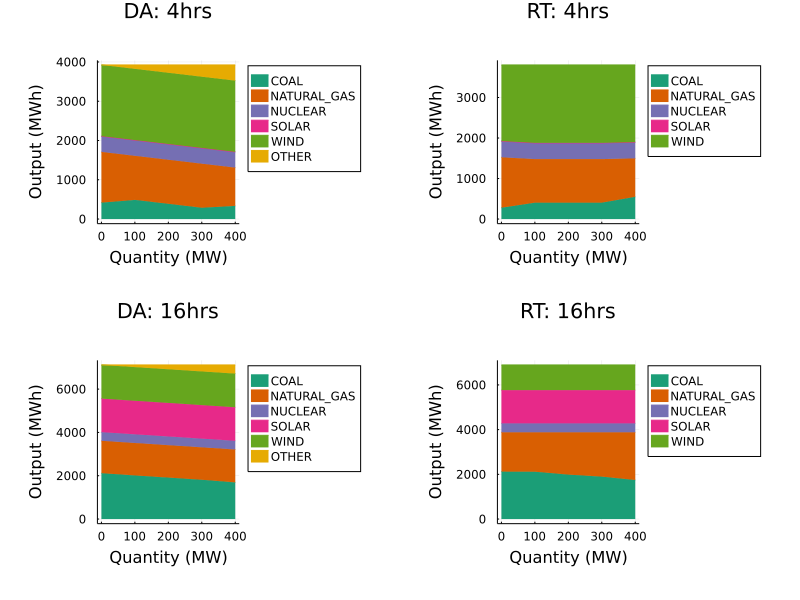

In [18]:
plot(plt_g[1,1,1], plt_g[1,1,2],plt_g[1,2,1], plt_g[1,2,2],layout=4,title=["DA: 4hrs" "RT: 4hrs" "DA: 16hrs" "RT: 16hrs"])

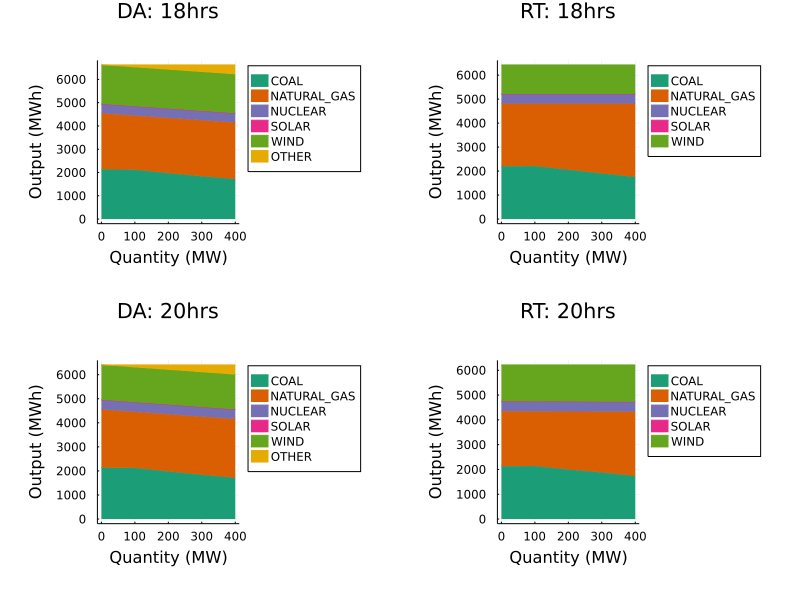

In [19]:
plot(plt_g[1,3,1], plt_g[1,3,2],plt_g[1,4,1], plt_g[1,4,2],layout=4,title=["DA: 18hrs" "RT: 18hrs" "DA: 20hrs" "RT: 20hrs"])

#### Generation in Austen when bidding in Austen

In [ ]:
plot(plt_g_A[1,1,1], plt_g_A[1,1,2],plt_g_A[1,2,1], plt_g_A[1,2,2],layout=4,title=["DA: 4hrs" "RT: 4hrs" "DA: 15hrs" "RT: 15hrs"])

In [ ]:
plot(plt_g_A[1,3,1], plt_g_A[1,3,2],plt_g_A[1,4,1], plt_g_A[1,4,2],layout=4,title=["DA: 18hrs" "RT: 18hrs" "DA: 20hrs" "RT: 20hrs"])

#### Economic viability

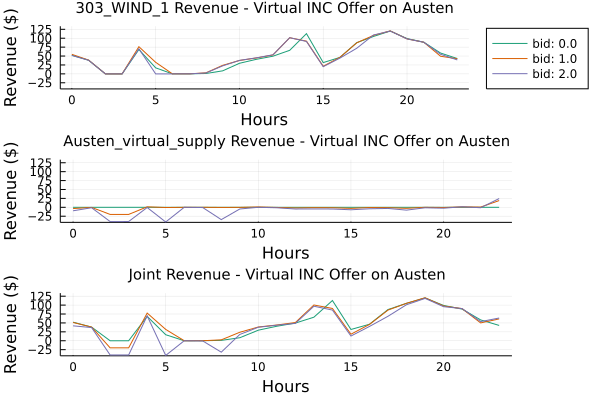

In [20]:
plt_rv[1]

### Generation - virtual offer on Bloch

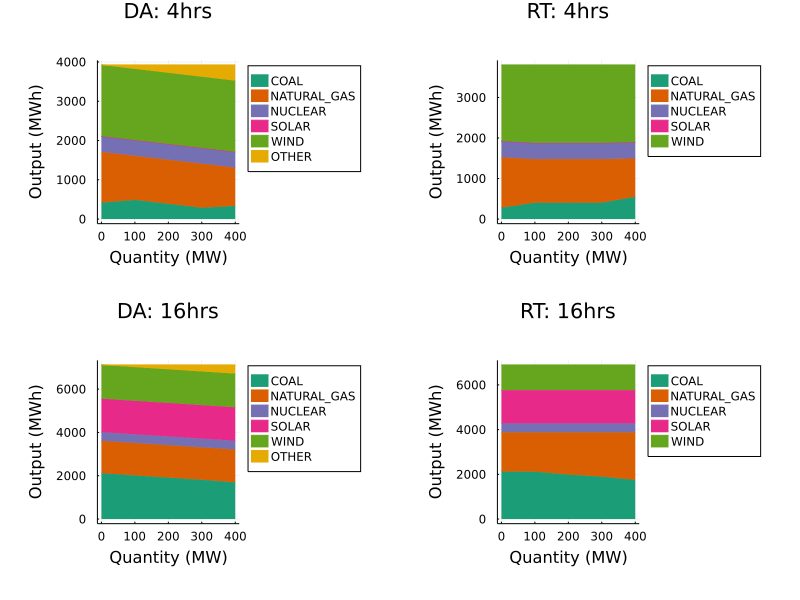

In [21]:
plot(plt_g[2,1,1], plt_g[2,1,2],plt_g[2,2,1], plt_g[2,2,2],layout=4,title=["DA: 4hrs" "RT: 4hrs" "DA: 16hrs" "RT: 16hrs"])

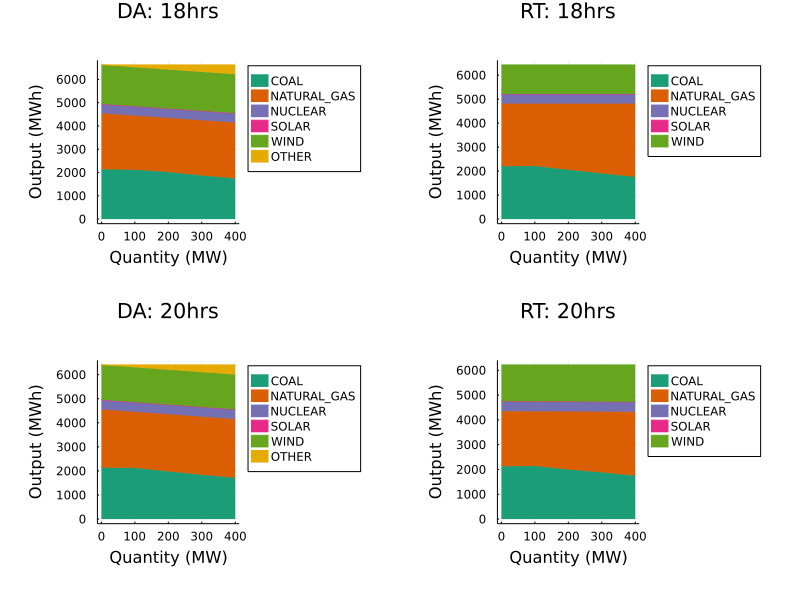

In [22]:
plot(plt_g[2,3,1], plt_g[2,3,2],plt_g[2,4,1], plt_g[2,4,2],layout=4,title=["DA: 18hrs" "RT: 18hrs" "DA: 20hrs" "RT: 20hrs"])

#### Generation in Bloch when bidding in Bloch

In [ ]:
plot(plt_g_B[2,1,1], plt_g_B[2,1,2],plt_g_B[2,2,1], plt_g_B[2,2,2],layout=4,title=["DA: 4hrs" "RT: 4hrs" "DA: 15hrs" "RT: 15hrs"])

In [ ]:
plot(plt_g_B[2,3,1], plt_g_B[2,3,2],plt_g_B[2,4,1], plt_g_B[2,4,2],layout=4,title=["DA: 18hrs" "RT: 18hrs" "DA: 20hrs" "RT: 20hrs"])

#### Economic viability

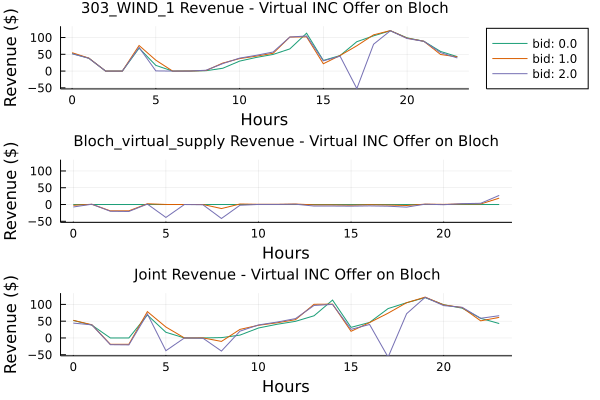

In [23]:
plt_rv[2]

### Generation - virtual offer on Chifa

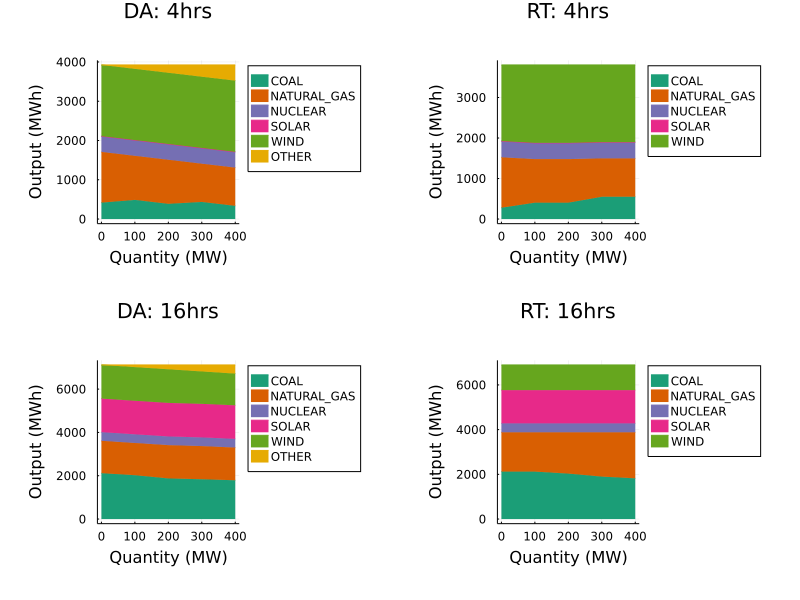

In [24]:
plot(plt_g[3,1,1], plt_g[3,1,2],plt_g[3,2,1], plt_g[3,2,2],layout=4,title=["DA: 4hrs" "RT: 4hrs" "DA: 16hrs" "RT: 16hrs"])

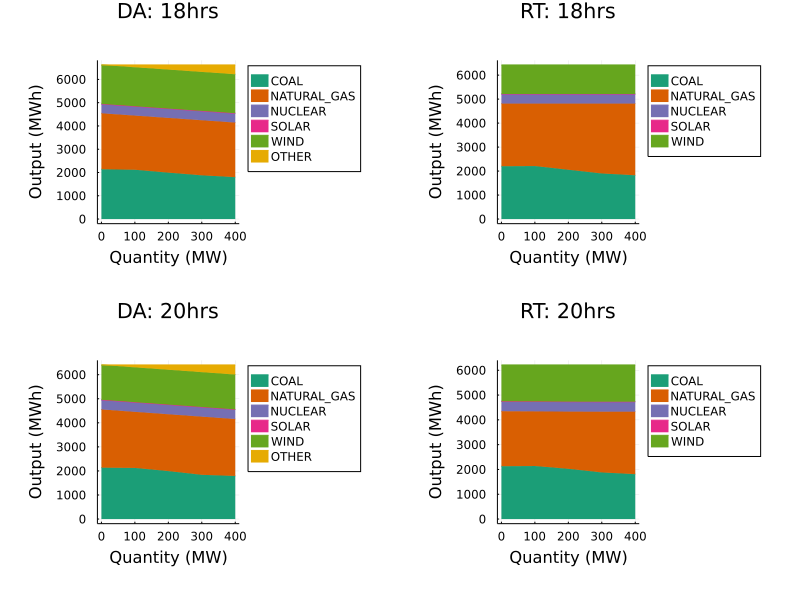

In [25]:
plot(plt_g[3,3,1], plt_g[3,3,2],plt_g[3,4,1], plt_g[3,4,2],layout=4,title=["DA: 18hrs" "RT: 18hrs" "DA: 20hrs" "RT: 20hrs"])

#### Generation in Chifa when bidding in Chifa

In [ ]:
plot(plt_g_C[3,1,1], plt_g_C[3,1,2], plt_g_C[3,2,1], plt_g_C[3,2,2],layout=4,title=["DA: 4hrs" "RT: 4hrs" "DA: 15hrs" "RT: 15hrs"])

In [ ]:
plot(plt_g_C[3,3,1], plt_g_C[3,3,2], plt_g_C[3,4,1], plt_g_C[3,4,2],layout=4,title=["DA: 18hrs" "RT: 18hrs" "DA: 20hrs" "RT: 20hrs"])

#### Economic viability

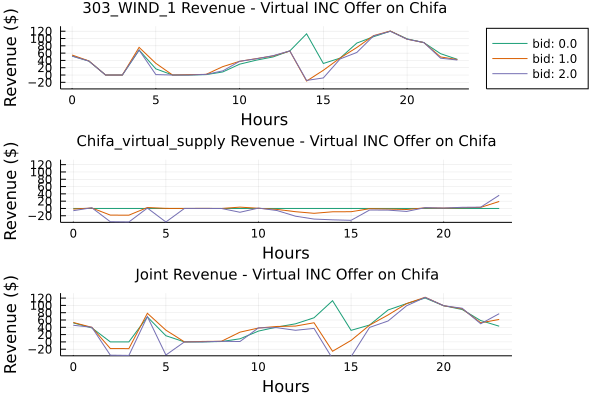

In [26]:
plt_rv[3]

### Balanced and imbalanced bids/offers: Do they have different impacts?

#### Sell in Austen -> Buy in Aubrey

[Fig. up] Coal generation for combinations of virtual sell offers at node Austen (xlabel) and virtual buy offers at node Aubrey (ylabel) in percentage to coal generation in a context of no virtual offer. On the main diagonal the balanced offers are displayed.

[Fig. down] Coal generation for combinations of virtual sell offers at node Austen (xlabel) and virtual buy offers at node Aubrey (ylabel) in percentage to coal generation in a context of no virtual offer. Cases with real time usage of fast-starters/energy spillage are set to 2.0.

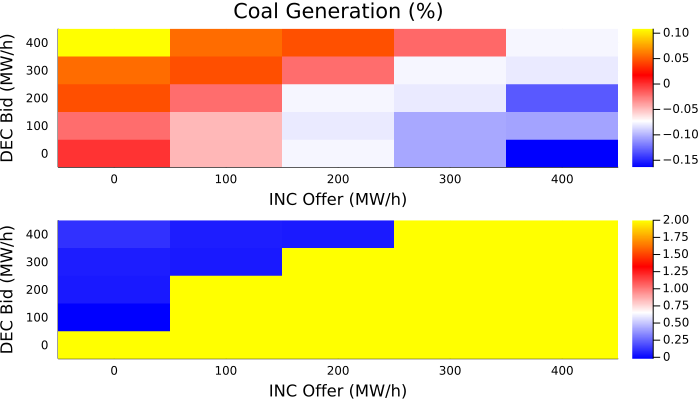

In [27]:
plt_mix[1]["coal"]

[Fig. up] Set to 1.0 if fast-starters/energy Spillage is needed. Set to 0.0 otherwise.

[Fig. middle] Amount of energy needed from fast-starters.

[Fig. down] Amount of energy  spillage needed.

In [ ]:
plt_mix[1]["deficit"]

Busines model: Revenue from a joint trade into the market. Wind power plant & virtual offer/bid. 

The renewable generator analysed is the 102_WIND_1 because it is the wind generator with the higher PMax (MW) in Zone A and it is located in the Aubrey Bus (where we make the DEC Bid).

In [ ]:
plt_mix[1]["revenue"]

#### Sell in Bloch -> Buy in Barkla

[Fig. up] Coal generation for combinations of virtual sell offers at node Bloch (xlabel) and virtual buy offers at node Barkla (ylabel) in percentage to coal generation in a context of no virtual offer. On the main diagonal the balanced offers are displayed.

[Fig. down] Coal generation for combinations of virtual sell offers at node Bloch (xlabel) and virtual buy offers at node Barkla (ylabel) in percentage to coal generation in a context of no virtual offer. Cases with real time usage of fast-starters/energy spillage are set to 2.0.

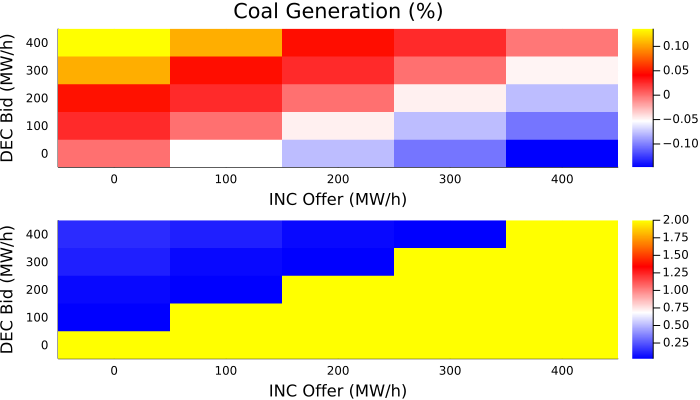

In [28]:
plt_mix[2]["coal"]

[Fig. up] Set to 1.0 if fast-starters/energy Spillage is needed. Set to 0.0 otherwise.

[Fig. middle] Amount of energy needed from fast-starters.

[Fig. down] Amount of energy  spillage needed.

In [ ]:
plt_mix[2]["deficit"]

Busines model: Revenue from a joint trade into the market. Solar power plant & virtual offer/bid.

The 215_PV_1 is a solar generator located in Zone B, same zone where the DEC Bid and the INC Offer are being made. It's located on Barton Bus.

The solar generator where we make the INC Offer (212_CSP_1 from Barkla Bus) was removed on the treatment of the data.

In [ ]:
plt_mix[2]["revenue"]

#### Sell in Chifa -> Buy in Caesar

[Fig. up] Coal generation for combinations of virtual sell offers at node Chifa (xlabel) and virtual buy offers at node Caesar (ylabel) in percentage to coal generation in a context of no virtual offer. On the main diagonal the balanced offers are displayed.

[Fig. down] Coal generation for combinations of virtual sell offers at node Chifa (xlabel) and virtual buy offers at node Caesar (ylabel) in percentage to coal generation in a context of no virtual offer. Cases with real time usage of fast-starters/energy spillage are set to 2.0.

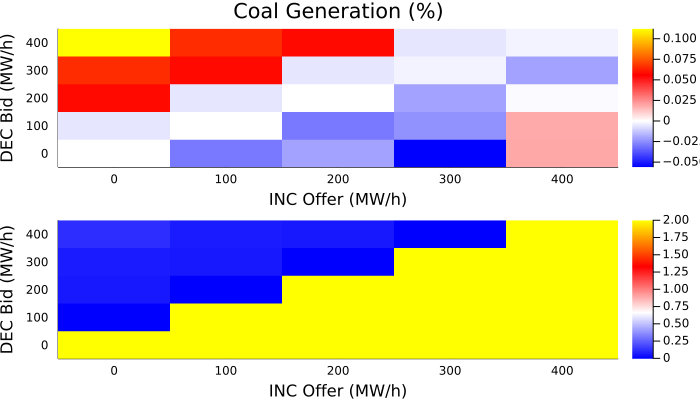

In [29]:
plt_mix[3]["coal"]

[Fig. up] Set to 1.0 if fast-starters/energy Spillage is needed. Set to 0.0 otherwise.

[Fig. middle] Amount of energy needed from fast-starters.

[Fig. down] Amount of energy  spillage needed.

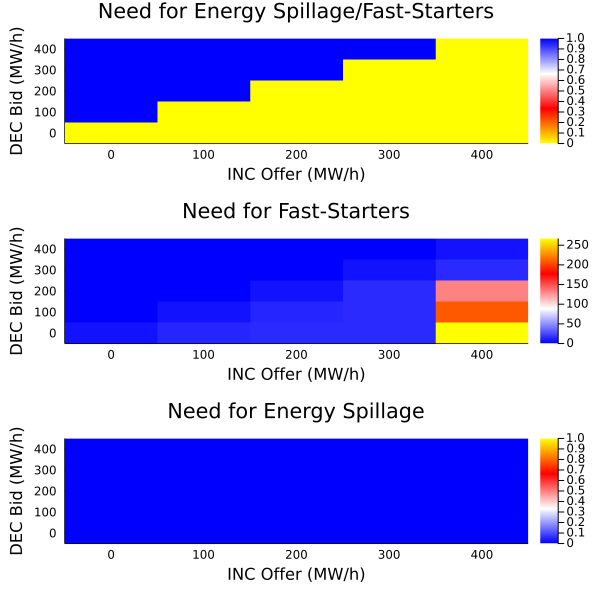

In [32]:
plt_mix[3]["deficit"]

Busines model: Revenue from a joint trade into the market. Wind power plant & virtual offer/bid.

The 303_WIND_1 is the wind generator with the higher PMax (MW). It is located in Caesar Bus (the bus from the Zone C where we make the DEC Bid).

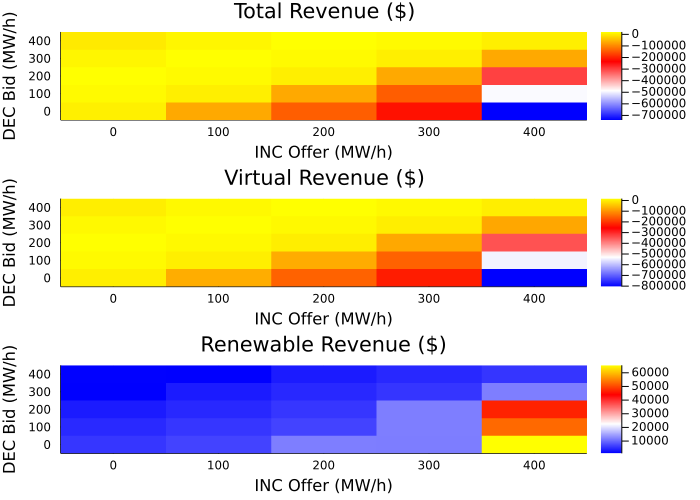

In [35]:
plt_mix[3]["revenue"]